In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Extract features

### Single file example extraction

In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

def extract_feature_array(filename, bands=21, frames=41):
    window_size = 512 * (frames-1)
    mfccs = []
    sound_clip, s = librosa.load(filename, sr=44100)
    for (start, end) in windows(sound_clip, window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
            mfccs.append(mfcc)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands).T.flatten()[:, np.newaxis].T
#             logspec = librosa.logamplitude(melspec)
#     log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
    return np.asarray(mfccs)

# # Uncomment if using deltas
#
#     log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
#     features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features)

# sample_filename = 'data/speech-accent-archive/recordings/afghanistan/dari2.mp3'
sample_filename = '/Users/leonmak/Documents/CS229/final-project/data/SC-scripted-word/CH/SC_W_CH_04_EN-chunk-5.wav'
features = extract_feature_array(sample_filename)
data_points, _ = librosa.load(sample_filename)
print ('IN: Initial Data Points =', len(data_points))
print ('OUT: Total features =', np.shape(features))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/leonmak/Documents/CS229/final-project/data/SC-scripted-word/CH/SC_W_CH_04_EN-chunk-5.wav'

# Classes

In [3]:
from sklearn import preprocessing

def iter_label_files(parent_dir):
    """Utility for extracting labels"""
    for root, dirpaths, fnames in os.walk(parent_dir):
        if len(dirpaths) > 0:
            continue
        label = root.split('/')[-1]
        yield root, label, fnames

# parent_dir = 'data/speech-accent-archive/recordings/'
parent_dir = 'data/SC-scripted-word/'
labels = []
for _, label, _ in iter_label_files(parent_dir):
    labels.append(label)
print(f'{len(labels)} labels found, First 5: {labels[:5]}')


10 labels found, First 5: ['CH', 'EN', 'IN', 'IR', 'IT']


In [4]:
cap = 2134
counts = []
for _, label, fnames in iter_label_files(parent_dir):
    counts.append(len(fnames))

top_indices_count = [i_count for i_count in sorted(enumerate(counts), key=lambda x:x[1], reverse=True)]
most_freq_egs = [labels[i] for (i, count) in top_indices_count if count >= cap]
print(f'Labels with >= {cap} egs: {most_freq_egs}, len:{len(most_freq_egs)}')    

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le_ed = le.fit_transform(most_freq_egs)
ohe_ed = ohe.fit_transform(le_ed.reshape(len(le_ed), 1))
print(ohe_ed.toarray())


Labels with >= 2134 egs: ['KO', 'EN', 'CH'], len:3
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


# Save features

In [6]:
import random 
import speechpy

NUM_MFCCS = 50
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 1  # seconds
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION


def get_label_enc(fn, le):
    fn_parts = fn.split('/')
    label_txt = fn_parts[-2]  # y_i
    label_int = le.transform([label_txt])
    return label_int[0]


def normalize_audio(source_files):
    fixed_lengths = [librosa.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]


def load_audio(source_files):
    loaded_mp3_files = [librosa.load(f) for f in source_files]
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    mfccs = [librosa.feature.mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs


def get_labels(fnames):
    labels = [get_label_enc(fn, le) for fn in fnames]
    return labels


def extract_feature(fnames):
    """
    Extract features from filenames to features and labels arrays
    """
    mfccs = load_audio(fnames)
    labels = get_labels(fnames)
    return np.asarray(mfccs), np.asarray(labels)
#     window_size = 512 * (frames-1)
#     log_specgrams = []
#     mfccs = []
#     labels = []
#     for fn in fnames:
#         sound_clip, s = librosa.load(fn)
# #         sound_clip -= np.mean(sound_clip)
# #         sound_clip /= max(sound_clip)
#         label_enc = get_label_enc(fn, le)
#         for (start, end) in windows(sound_clip, window_size):
#             signal = sound_clip[start:end]
#             if(len(signal) != window_size):
#                 break
#             labels.append(label_enc)
# #             melspec = librosa.feature.mfcc(signal, sr=s, n_mels=bands)
# #             logspec = librosa.logamplitude(melspec)
# #             log_specgrams.append(logspec)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
#             mfccs.append(mfcc)
#     if word == False:
#         log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
#     return np.asarray(mfccs), np.asarray(labels, dtype='int')
#     log_specgrams = np.array(log_specgrams).reshape(len(log_specgrams),bands,frames,2)
#     features = np.concatenate((log_specgrams, np.zeros(log_specgrams.shape)), axis=3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features), np.array(labels, dtype='int')


def get_subset_fnames():
    subset_fnames = []
    for root, label, fnames in iter_label_files(parent_dir):
        if label not in most_freq_egs:
            continue
        for fn in fnames[:cap]:
            if '.DS_Store' in fn:
                continue
            subset_fnames.append(os.path.join(root, fn))
    random.seed(24)
    random.shuffle(subset_fnames)
    return subset_fnames


def save_folds(save_dir, num_folds=10, fold_prefix='fold_orig_w'):
    fnames = get_subset_fnames()
    egs_per_fold = len(fnames) // num_folds
    curr = 0
    features = []
    labels = []
    for k in range(num_folds):
        fold_name = f'{fold_prefix}{str(k)}'
        
        feature_file = os.path.join(save_dir, fold_name + '_x.npy')
        labels_file = os.path.join(save_dir, fold_name + '_y.npy')

        print(f'Saving feature_file {feature_file} \nSaving labels_file {labels_file}')
        start_i = k * egs_per_fold
        end_i = (k + 1) * egs_per_fold
        fnames_fold = fnames[start_i: end_i]
        features, labels = extract_feature(fnames_fold)
#         features = np.concatenate([features, new_features]) if len(features) > 0 else np.asarray(new_features)
#         labels = np.concatenate([labels, new_labels]) if len(labels) > 0 else np.asarray(new_labels)
        print(f'Features of {fold_name} = {features.shape}')
        print(f'Labels of {fold_name} = {labels.shape}')

        np.save(feature_file, features)
        np.save(labels_file, labels)


save_dir=os.path.join('npy', 'mfcc_w')
save_folds(save_dir)


Saving feature_file npy/mfcc_w/fold_orig_w0_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w0_y.npy
Features of fold_orig_w0 = (639, 50, 44)
Labels of fold_orig_w0 = (639,)
Saving feature_file npy/mfcc_w/fold_orig_w1_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w1_y.npy
Features of fold_orig_w1 = (639, 50, 44)
Labels of fold_orig_w1 = (639,)
Saving feature_file npy/mfcc_w/fold_orig_w2_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w2_y.npy
Features of fold_orig_w2 = (639, 50, 44)
Labels of fold_orig_w2 = (639,)
Saving feature_file npy/mfcc_w/fold_orig_w3_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w3_y.npy
Features of fold_orig_w3 = (639, 50, 44)
Labels of fold_orig_w3 = (639,)
Saving feature_file npy/mfcc_w/fold_orig_w4_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w4_y.npy
Features of fold_orig_w4 = (639, 50, 44)
Labels of fold_orig_w4 = (639,)
Saving feature_file npy/mfcc_w/fold_orig_w5_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w5_y.npy
Features of fold_orig_w5 = (639, 50

# Load Features

In [7]:
from keras.utils import to_categorical
data_dir = os.path.join('npy', 'mfcc_w')
print(data_dir)
fold_prefix = 'fold_orig_w'

def add_folds(data_dir):
    files_lst = os.listdir(data_dir)
    num_folds = len(list(filter(lambda k: fold_prefix in k, files_lst))) // 2
        
    for k in range(num_folds-3):
        fold_name = f'{fold_prefix}{str(k)}'
        print("\nAdding " + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')

        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        
        # Data Augmentation with Gaussian Noise
        noise = np.random.normal(0,1, loaded_features.shape)
        loaded_features = np.concatenate([loaded_features, loaded_features+noise])
        loaded_labels = np.concatenate([loaded_labels, loaded_labels])
        
        print("New Features: ", loaded_features.shape, loaded_labels.shape)
        if k > 0:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
    return features, labels

train_x, train_y = add_folds(data_dir)

# use a fold for train-dev
valid_fold_name = f'{fold_prefix}7'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
train_dev_x = np.load(feature_file)
train_dev_y = np.load(labels_file) 

# use a fold for dev
valid_fold_name = f'{fold_prefix}8'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
dev_x = np.load(feature_file)
dev_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = f'{fold_prefix}9'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)


# encode
train_y = to_categorical(train_y)
train_dev_y = to_categorical(train_dev_y)
dev_y = to_categorical(dev_y)
test_y = to_categorical(test_y)

# train_x = np.expand_dims(np.asarray(train_x), axis=3)
# train_dev_x = np.expand_dims(np.asarray(train_dev_x), axis=3)
# dev_x = np.expand_dims(np.asarray(dev_x), axis=3)
# test_x = np.expand_dims(np.asarray(test_x), axis=3)

# trim data
# last = min([len(train_x), len(train_dev_x), len(dev_x), len(test_x)])
# train_dev_x, train_dev_y = train_dev_x, train_dev_y
# dev_x, dev_y = dev_x[:last], dev_y[:last]
# test_x, test_y = test_x[:last], test_y[:last]

print(f"\nTraining Set: {train_x.shape}, Labels: {train_y.shape}")
print(f"Train-dev Set: {train_dev_x.shape}, Labels: {train_dev_y.shape}")
print(f"Dev Set: {dev_x.shape}, Labels: {dev_y.shape}")
print(f"Test Set: {test_x.shape}, Labels: {test_y.shape}")


Using TensorFlow backend.


npy/mfcc_w

Adding fold_orig_w0
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w1
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w2
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w3
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w4
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w5
New Features:  (1278, 50, 44) (1278,)

Adding fold_orig_w6
New Features:  (1278, 50, 44) (1278,)

Training Set: (8946, 50, 44), Labels: (8946, 3)
Train-dev Set: (639, 50, 44), Labels: (639, 3)
Dev Set: (639, 50, 44), Labels: (639, 3)
Test Set: (639, 50, 44), Labels: (639, 3)


In [10]:
tf.set_random_seed(0)
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.regularizers import l2
from keras.utils import np_utils
from librosa.util import fix_length

bands = 50
frames = 1077
feature_size = bands * frames
num_labels = len(most_freq_egs)
input_shape = (bands, frames)
# input_shape=(bands, frames, num_channels) # if have delta num_channels = 1


def build_model():
    model = Sequential()
    f_size = 3
    model.add(Conv1D(128, f_size, activation='relu', input_shape=(50, 44)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, f_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
    model.add(Conv1D(24, f_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(124, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model
print("Building model...")
model = build_model()
model.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 48, 128)           17024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 128)           512       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 22, 64)            24640     
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 64)            256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 9, 24)             463

In [11]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop], 
                    epochs=30)

Training model...
Train on 9585 samples, validate on 639 samples
Epoch 1/30
9585/9585 [==============================] - 11s 1ms/step - loss: 0.5453 - acc: 0.8191 - val_loss: 0.3698 - val_acc: 0.8951
Epoch 2/30
9585/9585 [==============================] - 10s 996us/step - loss: 0.2120 - acc: 0.9567 - val_loss: 0.3632 - val_acc: 0.9077
Epoch 3/30
9585/9585 [==============================] - 10s 1ms/step - loss: 0.1215 - acc: 0.9839 - val_loss: 0.2830 - val_acc: 0.9264
Epoch 4/30
9585/9585 [==============================] - 9s 986us/step - loss: 0.1049 - acc: 0.9858 - val_loss: 0.2659 - val_acc: 0.9374
Epoch 5/30
9585/9585 [==============================] - 10s 1ms/step - loss: 0.0834 - acc: 0.9884 - val_loss: 0.2851 - val_acc: 0.9374
Epoch 6/30
9585/9585 [==============================] - 10s 1ms/step - loss: 0.0727 - acc: 0.9902 - val_loss: 0.2378 - val_acc: 0.9452
Epoch 7/30
9585/9585 [==============================] - 9s 973us/step - loss: 0.0479 - acc: 0.9965 - val_loss: 0.2666 - va

# K-fold cross validation

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

num_splits=3
cnn_estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=50, verbose=1)
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=1)
results = cross_val_score(cnn_estimator, train_x, train_y, cv=kfold)
print("{num_splits}-fold xval accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Examine Predictions

In [12]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  1.00000000e+00   1.43649773e-10   1.44615819e-10]
 [  1.17868251e-06   9.99987841e-01   1.09654211e-05]
 [  1.00000000e+00   8.87438922e-09   2.90474311e-08]
 ..., 
 [  3.03644955e-01   2.94879283e-05   6.96325541e-01]
 [  9.99455631e-01   3.44818225e-04   1.99578993e-04]
 [  7.98587294e-08   1.10972258e-04   9.99888897e-01]]
pred: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 2 1 0 2 0 1 2 1 1 2 1 1 0 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 2 2
 2 0 0 2 0 2 1 2 2 2 0 2 2 0 1 2 2 0 0 1 0 1 0 1 1 0]
test: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 0 1 0 2 0 1 2 1 1 2 1 1 0 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 2 2
 2 0 0 2 0 2 1 2 2 2 0 2 2 0 1 2 2 0 0 1 0 1 0 1 1 0]
639/639 [==============================] - 0s 544us/step
Accuracy = 0.95


In [ ]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# RNN

In [16]:


def rnn_model():        
    model = Sequential()
    model.add(LSTM(32, input_shape=(50, 1077), 
                   recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(32, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(24, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0000001), loss='categorical_crossentropy', metrics=['acc'])
    return model

print("Building model...")
model = build_model()
model.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 48, 128)           17024     
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 128)           512       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 24, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 64)            24640     
_________________________________________________________________
batch_normalization_11 (Batc (None, 22, 64)            256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 9, 24)             463

In [18]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop], 
                    epochs=16)

Training model...
Train on 9585 samples, validate on 639 samples
Epoch 1/16
9585/9585 [==============================] - 10s 1ms/step - loss: 0.0329 - acc: 0.9931 - val_loss: 0.1833 - val_acc: 0.9609
Epoch 2/16
9585/9585 [==============================] - 12s 1ms/step - loss: 0.0236 - acc: 0.9958 - val_loss: 0.2233 - val_acc: 0.9577
Epoch 3/16
9585/9585 [==============================] - 9s 968us/step - loss: 0.0200 - acc: 0.9970 - val_loss: 0.1739 - val_acc: 0.9609
Epoch 4/16
9585/9585 [==============================] - 10s 1ms/step - loss: 0.0165 - acc: 0.9985 - val_loss: 0.2006 - val_acc: 0.9609
Epoch 5/16
9585/9585 [==============================] - 9s 968us/step - loss: 0.0127 - acc: 0.9994 - val_loss: 0.1844 - val_acc: 0.9624
Epoch 6/16
9585/9585 [==============================] - 10s 1ms/step - loss: 0.0103 - acc: 0.9999 - val_loss: 0.1739 - val_acc: 0.9656
Epoch 7/16
9585/9585 [==============================] - 9s 959us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.1992 - val

In [19]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  9.99981165e-01   8.53080292e-06   1.02381446e-05]
 [  2.26778375e-05   9.99959826e-01   1.75069181e-05]
 [  9.99796093e-01   9.90396220e-05   1.04884486e-04]
 ..., 
 [  2.53954495e-04   3.26502282e-04   9.99419570e-01]
 [  9.98505950e-01   4.66120633e-04   1.02796080e-03]
 [  3.27962516e-05   4.45059995e-04   9.99522209e-01]]
pred: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 2 1 0 2 0 1 2 1 1 2 1 1 0 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 1 2
 2 0 0 2 0 2 1 2 2 1 0 2 2 0 1 2 2 0 0 1 0 1 0 1 1 0]
test: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 0 1 0 2 0 1 2 1 1 2 1 1 0 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 2 2
 2 0 0 2 0 2 1 2 2 2 0 2 2 0 1 2 2 0 0 1 0 1 0 1 1 0]
639/639 [==============================] - 0s 466us/step
Accuracy = 0.96


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


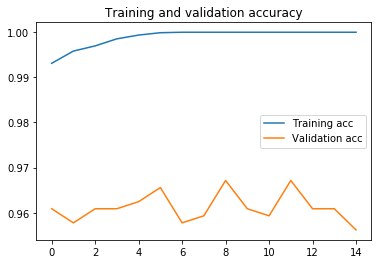

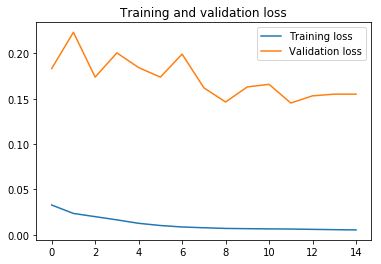

In [20]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
def mlp_model():        
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0000001), loss='categorical_crossentropy', metrics=['acc'])
    return model

print("Building model...")
model = build_model()
model.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 48, 128)           17024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 128)           512       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 24, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 22, 64)            24640     
_________________________________________________________________
batch_normalization_14 (Batc (None, 22, 64)            256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 9, 24)             463

In [22]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop], 
                    epochs=16)

Training model...
Train on 9585 samples, validate on 639 samples
Epoch 1/16
9585/9585 [==============================] - 11s 1ms/step - loss: 0.5475 - acc: 0.8146 - val_loss: 0.3844 - val_acc: 0.8983
Epoch 2/16
9585/9585 [==============================] - 9s 922us/step - loss: 0.2124 - acc: 0.9581 - val_loss: 0.3303 - val_acc: 0.9139
Epoch 3/16
9585/9585 [==============================] - 9s 950us/step - loss: 0.1351 - acc: 0.9802 - val_loss: 0.2726 - val_acc: 0.9343
Epoch 4/16
9585/9585 [==============================] - 9s 976us/step - loss: 0.1028 - acc: 0.9862 - val_loss: 0.2630 - val_acc: 0.9374
Epoch 5/16
9585/9585 [==============================] - 9s 946us/step - loss: 0.0844 - acc: 0.9901 - val_loss: 0.2442 - val_acc: 0.9358
Epoch 6/16
9585/9585 [==============================] - 9s 959us/step - loss: 0.0630 - acc: 0.9947 - val_loss: 0.2634 - val_acc: 0.9358
Epoch 7/16
9585/9585 [==============================] - 9s 944us/step - loss: 0.0487 - acc: 0.9968 - val_loss: 0.2702 - 

In [23]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  1.00000000e+00   5.63369273e-12   3.49122224e-11]
 [  3.71668676e-07   9.99999523e-01   8.21345054e-08]
 [  9.99999523e-01   8.59577725e-08   3.55601742e-07]
 ..., 
 [  6.92226862e-08   2.53749821e-08   9.99999881e-01]
 [  9.99956846e-01   6.87520105e-06   3.62594037e-05]
 [  3.84246277e-06   9.42848772e-02   9.05711234e-01]]
pred: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 0 1 0 2 0 1 2 1 1 2 1 1 2 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 2 2
 2 0 0 1 0 2 1 2 2 1 0 2 2 0 1 0 0 0 0 1 0 1 0 1 1 0]
test: [0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 1 1 2 0 1 0 1 0 2 0 1 2 1 1 2 1 1 0 1 0 0 1
 0 1 2 1 0 1 0 2 2 0 2 0 2 2 0 0 1 2 0 2 2 1 1 0 1 2 0 1 2 1 1 0 2 2 0 2 2
 2 0 0 2 0 2 1 2 2 2 0 2 2 0 1 2 2 0 0 1 0 1 0 1 1 0]
639/639 [==============================] - 0s 433us/step
Accuracy = 0.94


In [ ]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Train SVM

In [35]:
C_params = [0.1, 10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0, 0]

In [36]:
np.argmax(train_y, axis=1)

array([1, 1, 1, ..., 2, 2, 2])

In [37]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_plus_dev_x = np.concatenate([train_x, train_dev_x])
train_plus_dev_y = np.concatenate([train_y, train_dev_y])

for idx, C_param in enumerate(C_params):
    svm_rbf = SVC(C=C_param, kernel='rbf', probability=True)
    svm_rbf.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = svm_rbf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

KeyboardInterrupt: 

## Train Random Forest

In [39]:
C_params = [10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0]

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_plus_dev_x = np.concatenate([train_x, train_dev_x])
train_plus_dev_y = np.concatenate([train_y, train_dev_y])

for idx, C_param in enumerate(C_params):
    rf = RandomForestClassifier(n_estimators=C_param)
    rf.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = rf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

0.796557120501
0.881064162754
0.892018779343
0.904538341158
0.921752738654
0.926447574335
[0.79655712050078242, 0.88106416275430355, 0.892018779342723, 0.90453834115805942, 0.92175273865414709, 0.92644757433489833]


## Train Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

C_params = [10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0]
for idx, C_param in enumerate(C_params):
    gb = GradientBoostingClassifier(n_estimators=C_param)
    gb.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = rf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

0.926447574335
0.926447574335


KeyboardInterrupt: 